In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify
import copy
from functools import *

# Parameters

In [201]:
w    = [5,6]   #w[i] is transition frequency of qubit [i] 
wxx  = 0.01     #wxx is coupling energy
f    = [3,0] #f[i] is amplitude of microwave signal applied to qubit [i] 3
w_rf = [w[1], 0]  #w_rf[i] is frequency of --//--
phi  = [0, 0]  #phi[i] is phase of --//--
N    = [2,2]   #2lvls approximation

In [84]:
a = 30
b = 90
st = 3

In [85]:
args = {'a':a, 'b':b,'st':st, 'w_rf':w_rf[0],'phi':phi[0]}

In [187]:
time_coeff = "cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
tlist_t = 150
timesteps = 3000
tlist = np.linspace(0,tlist_t,timesteps)

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


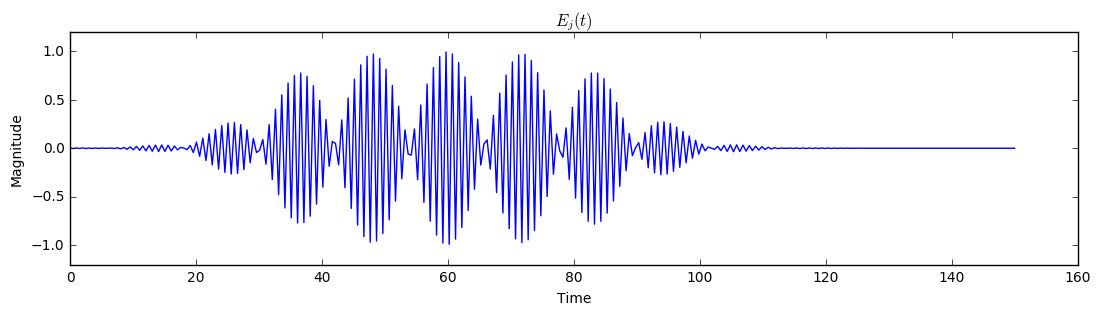

In [80]:
time_c_func = lambdify({'a','b','t','st','w_rf', 'phi'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=args['a'],b=args['b'],st=args['st'],w_rf=args['w_rf'],phi=args['phi'],t=tlist))
ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

# Operators definition

In [204]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, identity(N[1]))
    else:
        return tensor(identity(N[0]), oper)
def THq(qubit,w = w):
    return 0.5*w[qubit-1]*T(sigmaz(),qubit)
def THint(wxx = wxx):
    return 0.5*wxx*tensor(sigmax(), sigmax())
def THf(qubit, f=f):
    return f[qubit-1]*T(sigmax(),qubit)
def THsys_t():
    return [THq(1) + THq(2) + THint(),[THf(1), time_coeff]]
def THsys_t_new():
    return [THq(2) + THint(),[THf(1), time_coeff]]

def TSx(qubit, N = N):
    return T(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T(sigmam(),qubit, N)

# Visualisation

In [155]:
def Tvis_out(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes2d = plt.subplots(graphs,2, figsize=(13,5*graphs), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')

# Dynamics

In [196]:
expected = []
Tpsi0 = tensor(basis(2,1), basis(2,1))

def collapse_list():
    return []
def solve(expected_ops , with_progress_bar = True):
    if with_progress_bar:
        return mesolve(THsys_t(), Tpsi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(THsys_t(), Tpsi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [205]:
args['b'] = args['a'] + 62.93/2
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
out = solve([])

10.0%. Run time:   0.31s. Est. time left: 00:00:00:02
20.0%. Run time:   0.63s. Est. time left: 00:00:00:02
30.0%. Run time:   0.97s. Est. time left: 00:00:00:02
40.0%. Run time:   1.35s. Est. time left: 00:00:00:02
50.0%. Run time:   1.67s. Est. time left: 00:00:00:01
60.0%. Run time:   1.97s. Est. time left: 00:00:00:01
70.0%. Run time:   2.29s. Est. time left: 00:00:00:00
80.0%. Run time:   2.62s. Est. time left: 00:00:00:00
90.0%. Run time:   2.92s. Est. time left: 00:00:00:00
Total run time:   3.24s


In [194]:
def observe(output, operators, rotationFreq , every = 1):
    output2 = copy.deepcopy(output)
    output2.expect = []
    for i in range(len(operators)*2):
        output2.expect.append([])
    num_operators = len(operators)
    for time, state in zip(tlist[::every], output.states[::every]):
#         time = tlist_t / timesteps * time_step
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2

In [ ]:
output2 = observe(out, [TSx, TSy, TSz], [w[0],w[1]])
Tvis_out(output2)

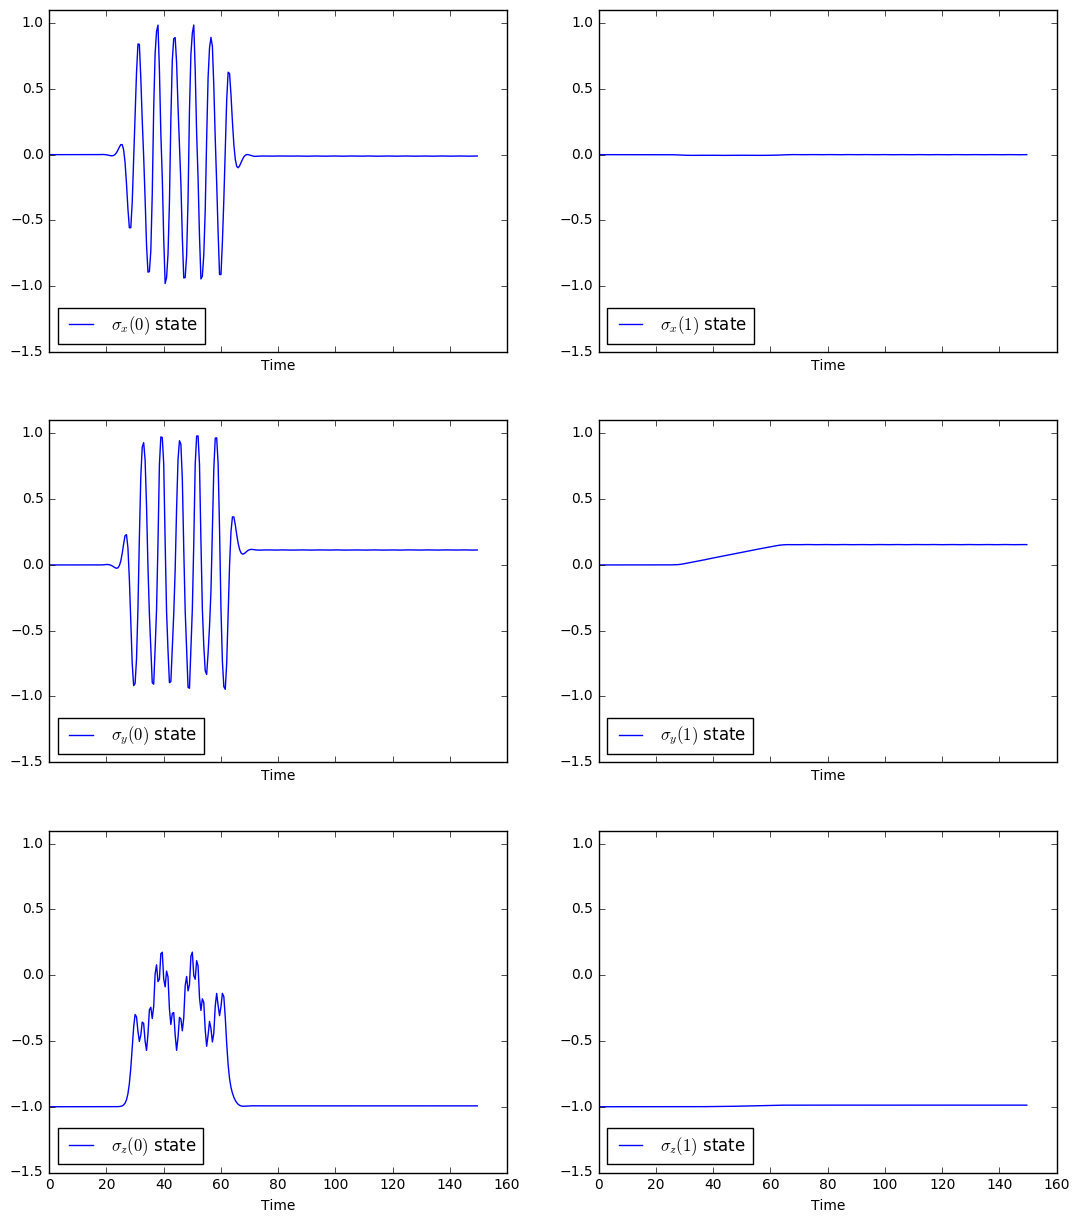

In [206]:
output2 = observe(out, [TSx, TSy, TSz], [w[0],w[1]],10)
Tvis_out(output2,10)

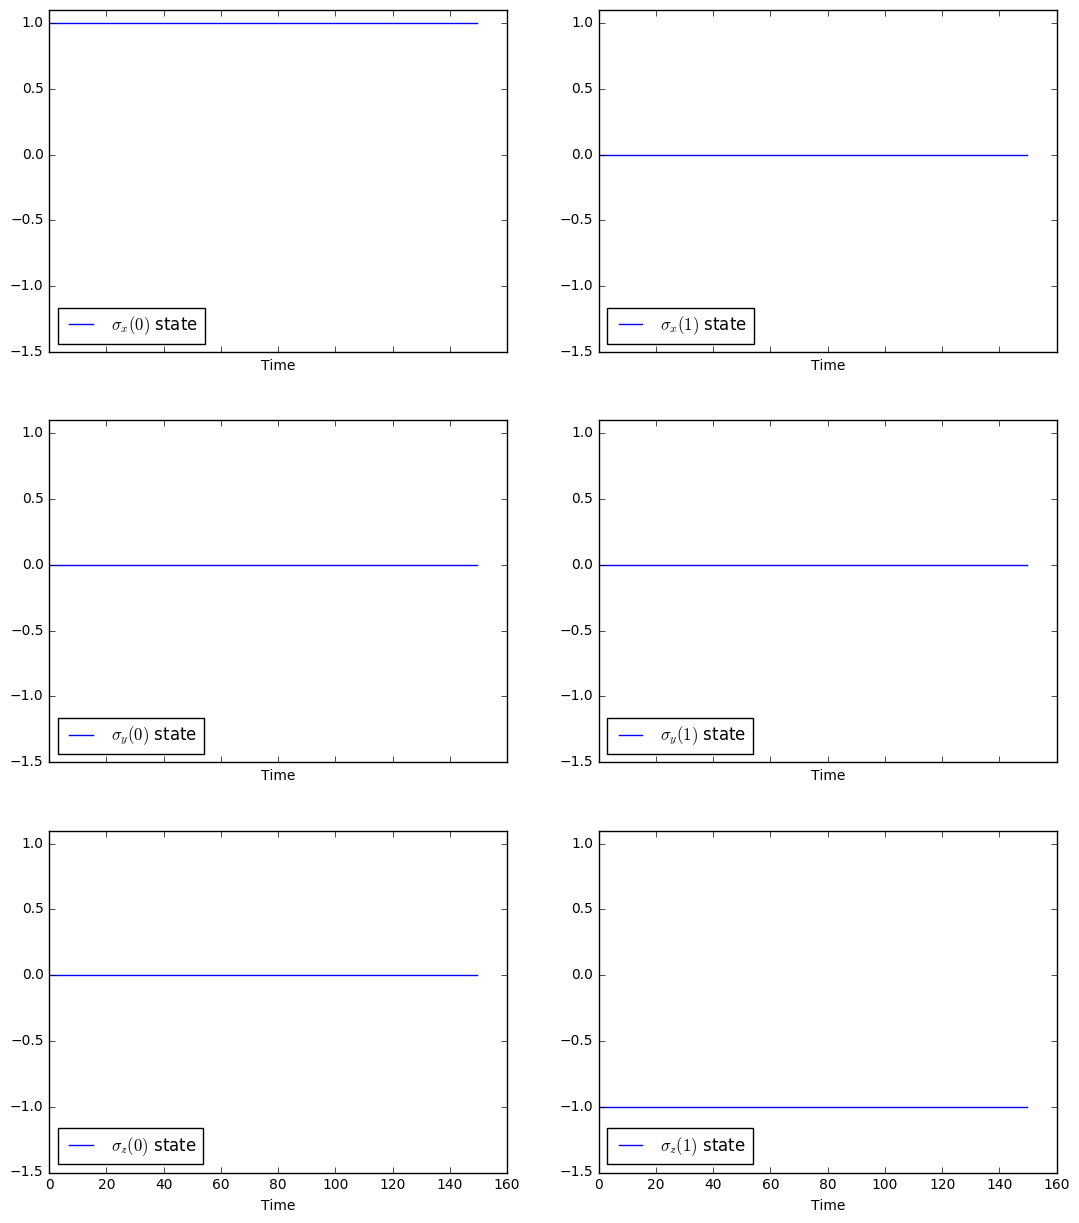

In [164]:

output2 = observe(out, [TSx, TSy, TSz], [0,0], 100)
Tvis_out(output2, 100)

In [221]:
expected = [TSz(2)]
def solve_b(expected, b, b_id):
    args['b'] = b
    print(b_id)
    return solve(expected, False)

sz_final = [ (solve_b(expected, b, b_id).expect[0][-1],b) for b_id, b in enumerate(np.linspace(82.8, 83.0,10)) ]

0
1
2
3
4
5
6
7
8
9


In [222]:
print(sz_final)

[(-0.98706692704703358, 82.799999999999997), (-0.98708201501921922, 82.822222222222223), (-0.98709483330193737, 82.844444444444449), (-0.98710534629494717, 82.86666666666666), (-0.98711351738752828, 82.888888888888886), (-0.98711932277855274, 82.911111111111111), (-0.98712273252834504, 82.933333333333337), (-0.98712372265249881, 82.955555555555549), (-0.98712227285338405, 82.977777777777774), (-0.98711836373772111, 83.0)]


In [37]:
ZX = (-0.5*1j*1/2*np.pi*tensor(sigmaz(),sigmax())).expm()

In [38]:
ZI = (0.5*1j*1/2*np.pi*tensor(sigmaz(),identity(2))).expm()

In [39]:
IX = (0.5*1j*1/2*np.pi*tensor(identity(2),sigmax())).expm()

In [40]:
CNOT = ZI*ZX*IX

In [45]:
CNOT*np.exp(-1j*np.pi/4)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]]

In [88]:
expect(TSz(2),ZX * Tpsi0)

-2.220446049250313e-16

In [180]:
new_t_list = np.linspace(0,2,100)
evolution = [(T(sigmaz(),1)*1j*2*np.pi/2 * t).expm()*Tpsi0 for t in new_t_list]

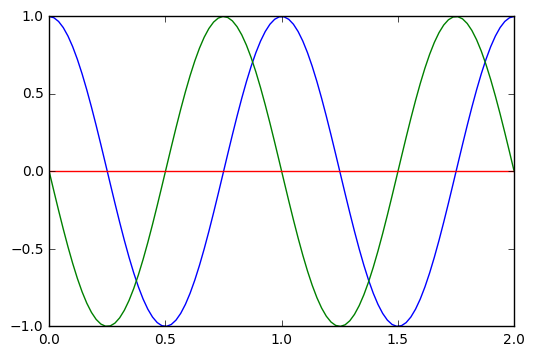

In [181]:
plt.plot(new_t_list, expect(TSx(1),evolution))
plt.plot(new_t_list, expect(TSy(1),evolution))
plt.plot(new_t_list, expect(TSz(1),evolution))
